In [1]:
import functools
import os
from time import time

import numpy as np
import pandas as pd
from estimagic import minimize
from sid import get_msm_func, get_simulate_func
from sid.msm import get_diag_weighting_matrix
import shutil

from src.calculate_moments import (
    smoothed_outcome_per_hundred_thousand_rki,
    smoothed_outcome_per_hundred_thousand_sim,
)
from src.config import BLD, SRC
from src.contact_models.get_contact_models import get_all_contact_models
from src.create_initial_states.create_initial_conditions import (  # noqa
    create_initial_conditions,
)
from src.manfred.minimize_manfred_estimagic import minimize_manfred_estimagic
from src.manfred.shared import hash_array
from src.plotting.plot_msm_performance import plot_msm_performance
from src.plotting.policy_gantt_chart import make_gantt_chart_of_policy_dict
from src.policies.full_policy_blocks import (
    get_german_reopening_phase,
    get_hard_lockdown,
    get_only_educ_closed,
    get_soft_lockdown,
)
from src.policies.policy_tools import combine_dictionaries
from estimagic.optimization.process_constraints import process_constraints
import seaborn as sns

def _get_free_params(params, constraints):
    pc, pp = process_constraints(constraints, params)
    return pp.query("_internal_free")

In [2]:
ESTIMATION_START = pd.Timestamp("2020-08-15")
ESTIMATION_END = pd.Timestamp("2020-12-05")
# ESTIMATION_END = pd.Timestamp("2020-08-17")

INIT_START = ESTIMATION_START - pd.Timedelta(31, unit="D")
INIT_END = ESTIMATION_START - pd.Timedelta(1, unit="D")
initial_states = pd.read_parquet(BLD / "data" / "initial_states.parquet")
share_known_cases = pd.read_pickle(BLD / "data" / "processed_time_series" / "share_known_cases.pkl")

In [3]:
initial_conditions = create_initial_conditions(
    start=INIT_START, end=INIT_END, seed=3484
)

In [4]:
contact_models = get_all_contact_models()

In [5]:
def get_estimation_policies(contact_models):
    reopening_end_multipliers = {"educ": 0.8, "work": 0.6, "other": 0.7}
    to_combine = [
        get_german_reopening_phase(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-04-23",
                "end_date": "2020-09-30",
                "prefix": "reopening",
            },
            start_multipliers={"educ": 0.5, "work": 0.2, "other": 0.3},
            end_multipliers=reopening_end_multipliers,
            educ_switching_date="2020-08-01",
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-10-01",
                "end_date": "2020-10-20",
                "prefix": "after_reopening",
            },
            multipliers=reopening_end_multipliers,
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-10-21",
                "end_date": "2020-11-01",
                "prefix": "anticipate_lockdown_light",
            },
            multipliers={"educ": 0.8, "work": 0.6, "other": 0.55},
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-11-02",
                "end_date": "2020-12-20",
                "prefix": "lockdown_light",
            },
            multipliers={"educ": 0.7, "work": 0.45, "other": 0.45},
        ),
    ]

    return combine_dictionaries(to_combine)

In [6]:
def parallelizable_msm_func(params, initial_states, initial_conditions, prefix, share_known_cases):

    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}"

    contact_models = get_all_contact_models()

    estimation_policies = get_estimation_policies(contact_models)

    simulate = get_simulate_func(
        params=params,
        initial_states=initial_states,
        contact_models=contact_models,
        contact_policies=estimation_policies,
        duration={"start": ESTIMATION_START, "end": ESTIMATION_END},
        initial_conditions=initial_conditions,
        share_known_cases=share_known_cases,
        path=path,
        saved_columns={
            "initial_states": ["age_group_rki"],
            "disease_states": ["newly_infected"],
            "time": ["date"],
            "other": ["new_known_case"],
        },
    )

    calc_moments = {
        "infections_by_age_group": functools.partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            groupby="age_group_rki",
        ),
    }

    data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
    data = data.loc[ESTIMATION_START:ESTIMATION_END]
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )

    empirical_moments = {
        "infections_by_age_group": smoothed_outcome_per_hundred_thousand_rki(
            df=data,
            outcome="newly_infected",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            group_sizes=age_group_info["n"],
        )
    }

    age_weights = age_group_info["weight"].to_dict()

    temp = empirical_moments["infections_by_age_group"].to_frame().copy(deep=True)
    temp["age_group"] = temp.index.get_level_values(1)
    temp["weights"] = temp["age_group"].replace(age_weights)

    weights = {"infections_by_age_group": temp["weights"]}

    weight_mat = get_diag_weighting_matrix(
        empirical_moments=empirical_moments,
        weights=weights,
    )

    def simulate_wrapper(params, simulate):
        return simulate(params)["time_series"]

    msm = get_msm_func(
        simulate=functools.partial(simulate_wrapper, simulate=simulate),
        calc_moments=calc_moments,
        empirical_moments=empirical_moments,
        replace_nans=lambda x: x * 1,
        weighting_matrix=weight_mat,
    )

    res = msm(params)
    shutil.rmtree(path)
    return res


pmsm = functools.partial(
    parallelizable_msm_func,
    initial_states=initial_states,
    initial_conditions=initial_conditions,
    prefix="gridsearch",
    share_known_cases=share_known_cases,
)

In [7]:
params = pd.read_pickle(BLD / "start_params.pkl")

hh_probs = ("infection_prob", "households", "households")
educ_models = [cm for cm in contact_models if "educ" in cm]
educ_probs = params.query(
    f"category == 'infection_prob' & subcategory in {educ_models}"
).index
work_models = [cm for cm in contact_models if "work" in cm]
work_probs = params.query(
    f"category == 'infection_prob' & subcategory in {work_models}"
).index
other_rec_models = [cm for cm in contact_models if "other" in cm and "non_recurrent" not in cm]
other_rec_probs = params.query(
    f"category == 'infection_prob' & subcategory in {other_rec_models}"
).index

other_non_rec_probs = ("infection_prob", "other_non_recurrent", "other_non_recurrent")
school_models = [
    cm
    for cm in contact_models
    if "educ" in cm and "school" in cm and not "preschool" in cm
]
school_probs = params.query(
    f"category == 'infection_prob' & subcategory in {school_models}"
).index

other_educ_probs = [
    ("infection_prob", "educ_nursery_0", "educ_nursery_0"),
    ("infection_prob", "educ_preschool_0", "educ_preschool_0"),
]

params.loc[educ_probs, "value"] = 0.02
params.loc[school_probs, "value"] = 0.012
params.loc[other_rec_probs, "value"] = 0.08
params.loc[other_non_rec_probs, "value"] = 0.05
params.loc[work_probs, "value"] = 0.08
params.loc[hh_probs, "value"] = 0.15
# currently this is starting with infection, not test demand
params.loc[("cd_received_test_result_true", "all", 2), "value"] = 0.1
params.loc[("cd_received_test_result_true", "all", 3), "value"] = 0.1
params.loc[("cd_received_test_result_true", "all", 4), "value"] = 0.2
params.loc[("cd_received_test_result_true", "all", 5), "value"] = 0.3
params.loc[("cd_received_test_result_true", "all", 6), "value"] = 0.3

params.loc["infection_prob", "lower_bound"] = 0.01
params.loc["infection_prob", "upper_bound"] = 0.15
params.loc[educ_probs, "upper_bound"] = 0.05
params.loc[hh_probs, "upper_bound"] = 0.25


constraints = [
    {"query": "category != 'infection_prob'", "type": "fixed"},
    {"loc": other_educ_probs, "type": "equality"},
    {"loc": other_rec_probs, "type": "equality"},
    {"loc": school_probs, "type": "equality"},
    {"loc": work_probs, "type": "equality"},
]


params.drop(("cd_received_test_result_true", "all", "2"), axis=0, inplace=True)


_get_free_params(params, constraints)

/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


lower_bound  \
category       subcategory           name                                 
infection_prob households            households                    0.01   
               educ_school_0         educ_school_0                 0.01   
               educ_preschool_0      educ_preschool_0              0.01   
               work_non_recurrent    work_non_recurrent            0.01   
               other_non_recurrent   other_non_recurrent           0.01   
               other_recurrent_daily other_recurrent_daily         0.01   

                                                            upper_bound  \
category       subcategory           name                                 
infection_prob households            households                    0.25   
               educ_school_0         educ_school_0                 0.05   
               educ_preschool_0      educ_preschool_0              0.05   
               work_non_recurrent    work_non_recurrent            0.15   
               other_non_recurrent   other_non_recurrent           0.15   
               other_recurrent_daily other_recurrent_daily         0.15   

                                                            value  \
category       subcategory           name                           
infection_prob households            households             0.150   
               educ_school_0         educ_school_0          0.012   
               educ_preschool_0      educ_preschool_0       0.020   
               work_non_recurrent    work_non_recurrent     0.080   
               other_non_recurrent   other_non_recurrent    0.050   
               other_recurrent_daily other_recurrent_daily  0.080   

                                                            _fixed_value  \
category       subcategory           name                                  
infection_prob households            households                      NaN   
               educ_school_0         educ_school_0                   NaN   
               educ_preschool_0      educ_preschool_0                NaN   
               work_non_recurrent    work_non_recurrent              NaN   
               other_non_recurrent   other_non_recurrent             NaN   
               other_recurrent_daily other_recurrent_daily           NaN   

                                                            _is_fixed_to_value  \
category       subcategory           name                                        
infection_prob households            households                          False   
               educ_school_0         educ_school_0                       False   
               educ_preschool_0      educ_preschool_0                    False   
               work_non_recurrent    work_non_recurrent                  False   
               other_non_recurrent   other_non_recurrent                 False   
               other_recurrent_daily other_recurrent_daily               False   

                                                            _post_replacements  \
category       subcategory           name                                        
infection_prob households            households                             -1   
               educ_school_0         educ_school_0                          -1   
               educ_preschool_0      educ_preschool_0                       -1   
               work_non_recurrent    work_non_recurrent                     -1   
               other_non_recurrent   other_non_recurrent                    -1   
               other_recurrent_daily other_recurrent_daily                  -1   

                                                            _is_fixed_to_other  \
category       subcategory           name                                        
infection_prob households            households                          False   
               educ_school_0         educ_school_0                       False   
               educ_preschool_0      educ_preschool_0 

In [8]:
msm_res = pmsm(params)

Start the simulation...
2020-12-05: 100%|██████████| 113/113 [19:47<00:00, 10.51s/it]


In [9]:
msm_res["value"]

139.94077888355037

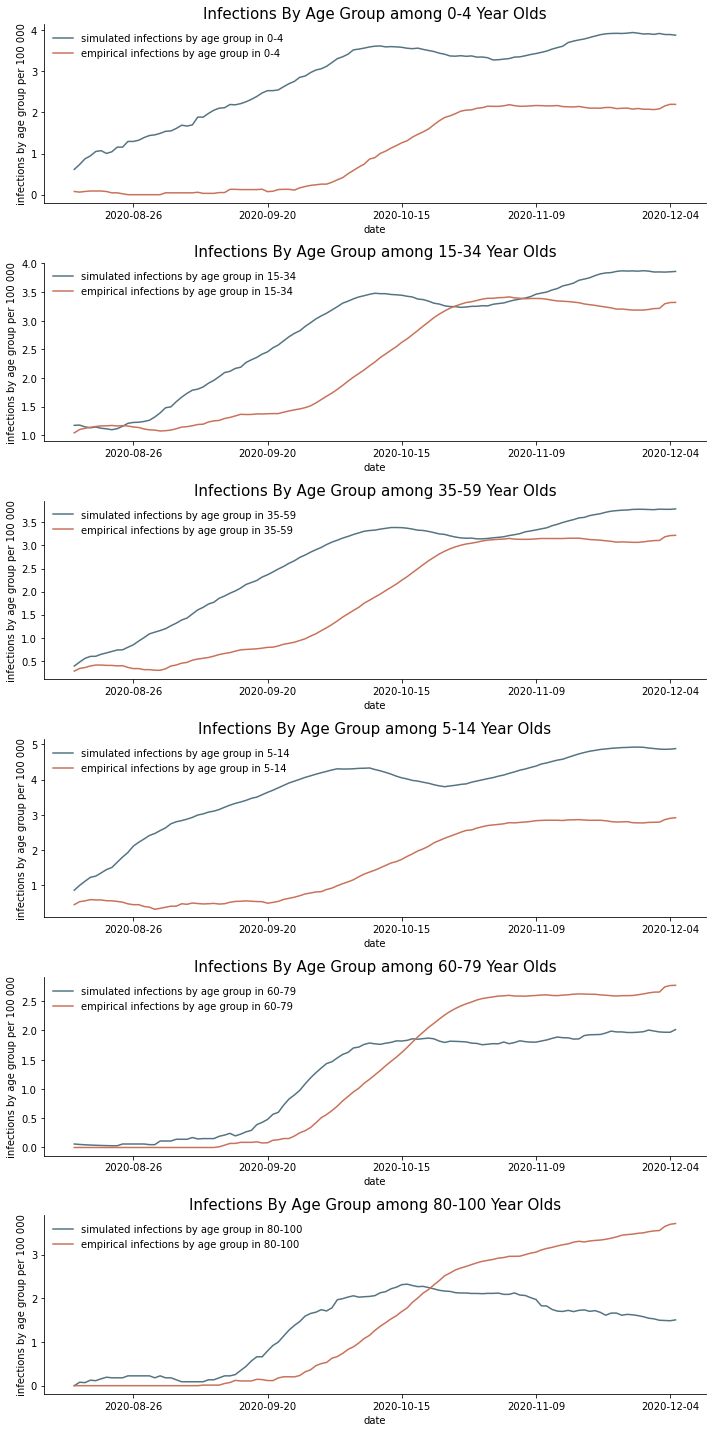

In [10]:
fig, ax = plot_msm_performance(msm_res)

In [11]:
algo_options = {
    "step_sizes": [0.2, 0.1, 0.05],
    "max_step_sizes": [0.3, 0.2, 0.2],
    "linesearch_n_points": 12,
    "gradient_weight": 0.5,
    "noise_n_evaluations_per_x": [5, 10, 10],
    "convergence_relative_params_tolerance": 0.001,
    "direction_window": 3,
    "batch_evaluator_options": {"n_cores": 20},
}

In [ ]:
res = minimize(
    criterion=pmsm,
    params=params,
    algorithm=minimize_manfred_estimagic,
    algo_options=algo_options,
    logging="first_manfred_attempt.db",
    constraints=constraints,
)

Start the simulation...
2020-12-05: 100%|██████████| 113/113 [19:28<00:00, 10.34s/it]
/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
